In [1]:
import sys
sys.path.append('../')

from utils.fit_ellipse import transform_tensor_batched, ellipse_params_batched, plot_batch_with_ellipses
from utils.utils_data import get_dataloader
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_path='/home/michaelbertagna/git/Galaxy-Deconv/simulated_datasets/LSST_23.5_deconv'
train_val_split=0.8
batch_size=2
train_loader, val_loader = get_dataloader(data_path=data_path, train=True, train_val_split=train_val_split, batch_size=batch_size)

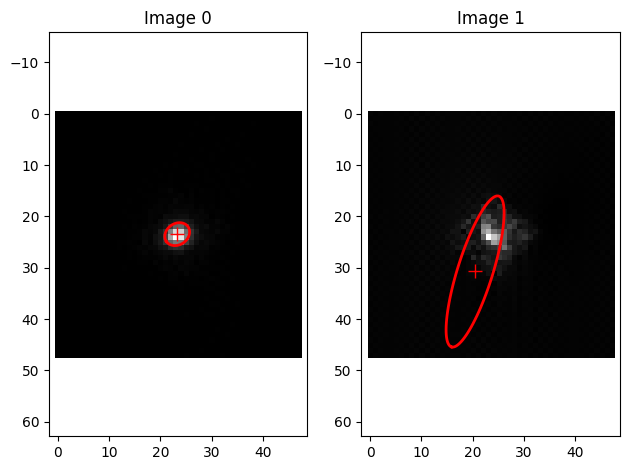

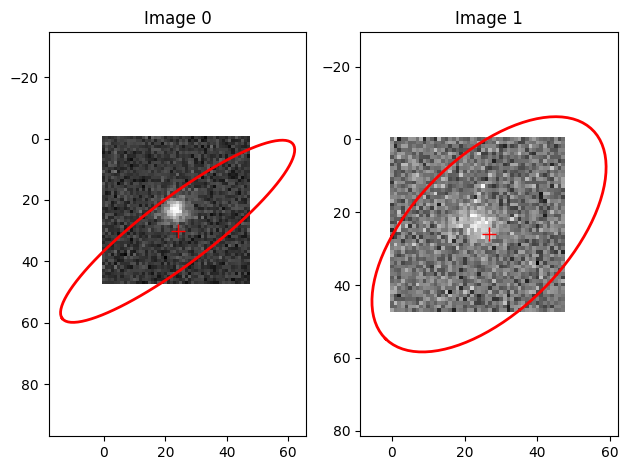

In [ ]:
import time
from IPython.display import clear_output

pps = [0.3, 0.4, 0.5, 0.6, 0.7]

for idx, ((obs, psf, alpha), gt) in enumerate(train_loader):
    clear_output()
    fig, axes = plot_batch_with_ellipses(gt, [ellipse_params_batched(transform_tensor_batched(gt), peak_pos=pp)[0] for pp in pps], num_cols=2)
    plt.show()
    fig, axes = plot_batch_with_ellipses(obs, [ellipse_params_batched(transform_tensor_batched(obs), peak_pos=pp)[0] for pp in pps], num_cols=2)
    plt.show()
    time.sleep(2)